Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### Read the data

### Importing all the important libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import os
import PIL
import pathlib
import glob
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.models import Sequential
import cv2
import google.colab
from google.colab import drive


In [ ]:
print('library - ', pd.__name__,' version ' ,pd.__version__)
print('library - ',np.__name__,' version ',np.__version__)
print('library - ',sns.__name__,' version ',sns.__version__)
print('library - ',matplotlib.__name__,' version ',matplotlib.__version__)
print('library - ', sns.__name__,' version ' ,sns.__version__)
print('library - ',PIL.__name__,' version ',PIL.__version__)
print('library - ',tf.__name__,' version ',tf.__version__)
print('library - ',keras.__name__,' version ',keras.__version__)
print('library - ',cv2.__name__,' version ',cv2.__version__)
print('library - ',google.colab.__name__,' version ',google.colab.__version__)

library -  pandas  version  1.5.3
library -  numpy  version  1.23.5
library -  seaborn  version  0.12.2
library -  matplotlib  version  3.7.1
library -  seaborn  version  0.12.2
library -  PIL  version  9.4.0
library -  tensorflow  version  2.12.0
library -  keras.api._v2.keras  version  2.12.0
library -  cv2  version  4.7.0
library -  google.colab  version  0.0.1a2


In [ ]:
# mounting the google drive:
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [ ]:
!ls /content/gdrive/MyDrive/UpGrad/'Skin cancer ISIC The International Skin Imaging Collaboration'/Train

'actinic keratosis'	 melanoma		      'seborrheic keratosis'
'basal cell carcinoma'	 nevus			      'squamous cell carcinoma'
 dermatofibroma		'pigmented benign keratosis'  'vascular lesion'


### **Task 1:** Update the paths of the train and test dataset

In [ ]:
# Defining the path for train and test images

data_dir_train = pathlib.Path("/content/gdrive/MyDrive/UpGrad/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path("/content/gdrive/MyDrive/UpGrad/Skin cancer ISIC The International Skin Imaging Collaboration/Test")

In [ ]:
print('Total files in Train directory ', len(list(data_dir_train.glob('*/*.*'))))
print('Total files in Test directory ',len(list(data_dir_test.glob('*/*.*'))))

image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print('Total jpg in Train directory ',image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print('Total jpg in Test directory ',image_count_test)

Total files in Train directory  2239
Total files in Test directory  118
Total jpg in Train directory  2239
Total jpg in Test directory  118


### **Task 2:** Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [ ]:
batch_size = 32
img_height = 180
img_width = 180
np.random.seed(123)
tf.random.set_seed(123)

Use 80% of the images for training, and 20% for validation.

In [ ]:
## Training dataset with resized image (180, 180) and seed=123, Seed is set to avoid randomness in picking the data for processing.
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)



Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [ ]:
## Validation dataset with resized image (180, 180) and seed=123, Seed is set to avoid randomness in picking the data for processing.
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)



Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [ ]:
# List out all the classes of skin cancer and store them in a list using class_names attribute of the datasets.
# class_names correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### **Task 3:** Visualize the data
#### Visualize one instance of all the nine classes present in the dataset

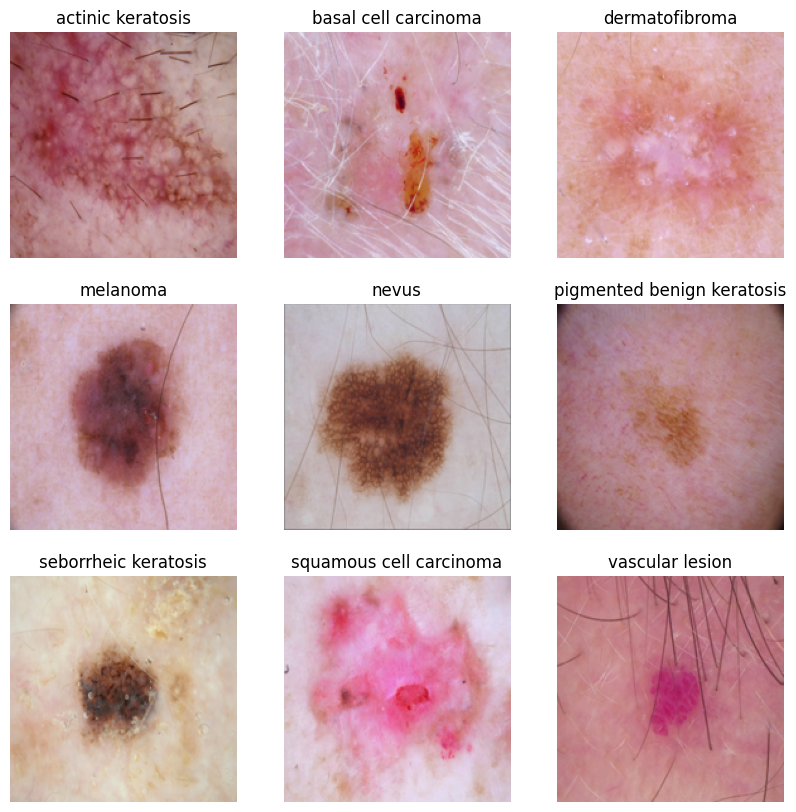

In [ ]:
# Visualize
def visualize_one_image_of_each_category(*, pData_dir_train, pClass_names):
  plt.figure(figsize=(10, 10))
  for i, class_name in enumerate(pClass_names):
    # Sort the images to makes sure, we get to see the same image every time we execute the code
    images_of_class = sorted(list(pData_dir_train.glob(class_name + '/*.jpg')))
    image = PIL.Image.open(str(images_of_class[0]))
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image.resize((img_height, img_width)))
    plt.title(class_name)
    plt.axis("off")
  plt.show()
# visualize_one_image_of_each_category
visualize_one_image_of_each_category(pData_dir_train = data_dir_train, pClass_names = class_names)

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### **Task 4:** Create the model
#### CNN model, which can accurately detect 9 classes present in the dataset. Using ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [ ]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)), # With rescaling we are also making sure the values will be in floats for accuracy as well as it helps a bit with performance while training the model as it avoid data type conversion from int to float.
  layers.Conv2D(filters = 16, kernel_size = 3, padding='same', activation='relu'), # padding='same', which means zero padding with original dimension is retained. To avoid the quick data loss we are using padding. Furthermore, the stride is 1 by default and we will stick with it to let the model learn every part of image
  layers.MaxPooling2D(), # Default pool_size = (2, 2)
  layers.Conv2D(filters = 32, kernel_size = 3, padding='same', activation='relu'),
  layers.MaxPooling2D(), # Default pool_size = (2, 2)
  layers.Conv2D(filters = 64, kernel_size = 3, padding='same', activation='relu'),
  layers.MaxPooling2D(), # Default pool_size = (2, 2)
  layers.Flatten(), # Flatten the data to feed into dense network
  layers.Dense(units = 128, activation='relu'), # dense layer with 128 neuron
  layers.Dense(units = num_classes) #  # dense layer with 9 neuron to predict 9 different categories
])


### **Task 5:** Compile the model
Choose an appropirate optimiser and loss function for model training

In [ ]:
### Choosing adam optimiser and SparseCategoricalCrossentropy loss function
### We are using SparseCategoricalCrossentropy as loss function since we have loaded the images with deafault label_mode='int',
### which assigns integer numbers to each directory, which in our case is the class of images
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),# Set from_logits=True to apply softmax activation to output
              metrics=['accuracy'])

In [ ]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

### **Task 6:** Train the model

In [ ]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 317s 1s/step - loss: 2.0583 - accuracy: 0.2388 - val_loss: 1.9976 - val_accuracy: 0.2953
Epoch 2/20
56/56 [==============================] - 1s 25ms/step - loss: 1.7335 - accuracy: 0.3973 - val_loss: 1.5864 - val_accuracy: 0.4765
Epoch 3/20
56/56 [==============================] - 1s 24ms/step - loss: 1.4619 - accuracy: 0.4749 - val_loss: 1.4374 - val_accuracy: 0.5280
Epoch 4/20
56/56 [==============================] - 1s 24ms/step - loss: 1.4059 - accuracy: 0.5095 - val_loss: 1.4465 - val_accuracy: 0.5056
Epoch 5/20
56/56 [==============================] - 1s 23ms/step - loss: 1.3173 - accuracy: 0.5363 - val_loss: 1.4738 - val_accuracy: 0.4609
Epoch 6/20
56/56 [==============================] - 1s 23ms/step - loss: 1.2797 - accuracy: 0.5424 - val_loss: 1.5291 - val_accuracy: 0.4720
Epoch 7/20
56/56 [==============================] - 1s 22ms/step - loss: 1.1785 - accuracy: 0.5787 - val_loss: 1.3623 - val_accuracy: 0.5414
Epoch 8/20
56

### **Task 7:** Visualizing training results

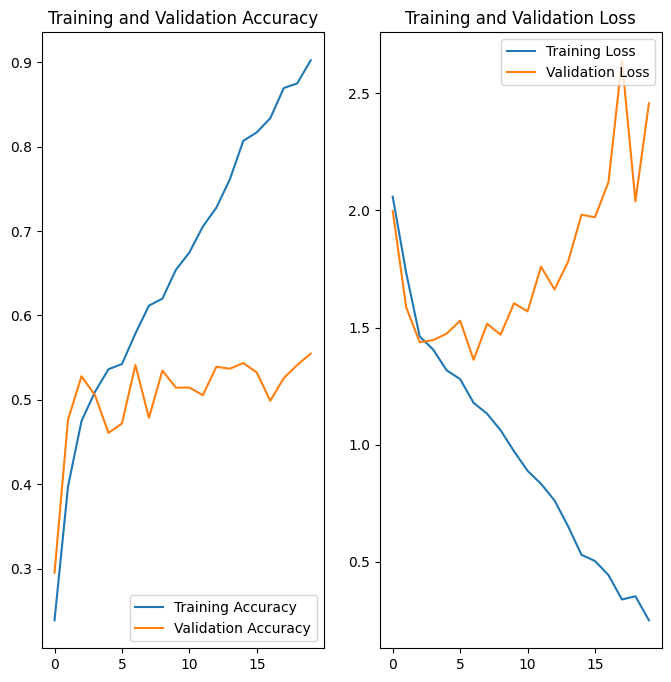

In [ ]:
def visualize_training_results(*, phistory, pepochs):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs_range = range(pepochs)

  plt.figure(figsize=(8, 8))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()

# visualize_training_results
visualize_training_results(phistory = history, pepochs = epochs)

### **Task 8:** Observations from the CNN model built

#### The plots show that training accuracy and validation accuracy are off by large margins, and the model has achieved only around ~54% accuracy on the validation set. But, it has an accuracy of ~88% with training set.

#### Model is clearly Overfitting
* We can see that the accuracy of the model with training dataset is increasing over time with each epoch, reaching an accuracy of 85%+, whereas the accuracy of the validation dataset stalls around 50-55%. Furthermore, the difference between accuracy of training and validation dataset is ~30%+, which is a huge difference and the model is clearly Overfitting.
* The overfitting in this case is most likely due to less number of images in the dataset we are giving to the model for learning and the model could be learning from noise or unwanted data.
* Overfitting problem could be solved through data augmentation and adding dropout layers in the model.


#### Data augmentation,  takes the approach of generating additional training data from existing images by augmenting them using random transformations that yield believable-looking images. This helps expose the model to more aspects of the data and generalize better.

#### Dropout is a regularization technique to avoid overfitting in the network. Applying a dropout to a layer will result in randomly dropping out a number of output units from the layer during the training process by setting the activation to zero.

### **Task 9:** Build a model with Data augumentation strategy.

### Task **9.1:** Data augumentation

In [ ]:
# Data augumentation
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

### **Task 9.2:**  Visualize a sample images with augmentation

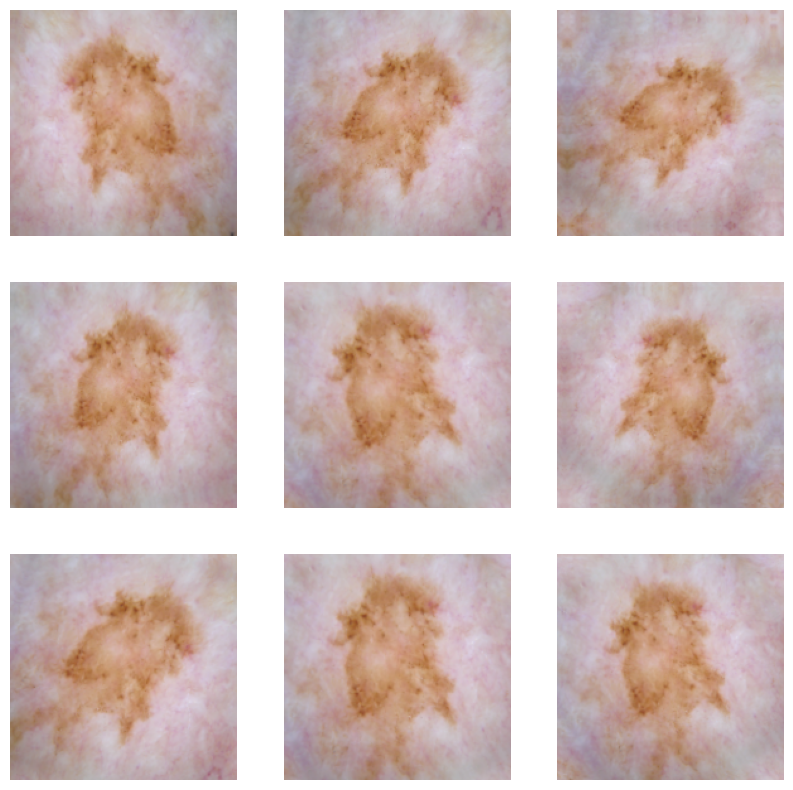

In [ ]:
# Visualize how your augmentation strategy works for one instance of training image.
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

### **Task 9.3:** Create the model, compile and train the model with data augmentation layer


In [ ]:
## Model with Data Augmentation layer in the begining and adding 20% dropout after 3rd maxpooling layer

model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),# adding 20% dropout to avoid overfit
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])



### **Task 9.4:** Compiling the model with data augmentation layer

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

### **Task 9.5:** Training the model with data augmentation layer

In [ ]:
epochs = 20
history = model.fit(
  x =  train_ds,
  validation_data = val_ds,
  epochs = epochs
)

Epoch 1/20
56/56 [==============================] - 4s 36ms/step - loss: 1.9435 - accuracy: 0.2712 - val_loss: 1.8091 - val_accuracy: 0.3311
Epoch 2/20
56/56 [==============================] - 2s 31ms/step - loss: 1.5952 - accuracy: 0.4431 - val_loss: 1.4499 - val_accuracy: 0.5235
Epoch 3/20
56/56 [==============================] - 2s 30ms/step - loss: 1.4477 - accuracy: 0.4939 - val_loss: 1.4607 - val_accuracy: 0.5123
Epoch 4/20
56/56 [==============================] - 2s 30ms/step - loss: 1.4253 - accuracy: 0.4939 - val_loss: 1.3606 - val_accuracy: 0.5570
Epoch 5/20
56/56 [==============================] - 2s 30ms/step - loss: 1.3843 - accuracy: 0.5151 - val_loss: 1.3367 - val_accuracy: 0.5235
Epoch 6/20
56/56 [==============================] - 2s 30ms/step - loss: 1.3274 - accuracy: 0.5340 - val_loss: 1.2925 - val_accuracy: 0.5638
Epoch 7/20
56/56 [==============================] - 2s 30ms/step - loss: 1.2942 - accuracy: 0.5536 - val_loss: 1.2665 - val_accuracy: 0.5481
Epoch 8/20
56

### **Task 9.6:** Visualizing the results with data augmentation layer

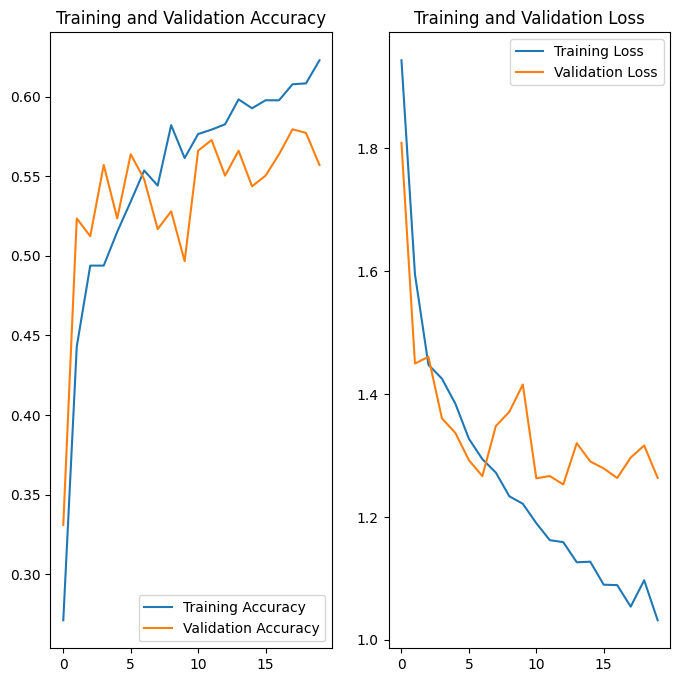

In [ ]:
# visualize_training_results
visualize_training_results(phistory = history, pepochs = epochs)

#### **Question**: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

### **Findings:** With Data Augmentation and adding dropouts to the output of 3rd maxpooling, we could see that the overfitting is reduce. Now, the training and validation accuracy are closer aligned. Accuracy of the model with traing dataset is ~62% and with validation dataset, it is ~58%. The accuracy of the model is not great, we could try and tweak the model to see if we can improve the performance.

#### **Task 10:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [ ]:
# Path list
path_list = list(data_dir_train.glob('*/*.jpg'))
# Lesion list
lesion_list = [os.path.basename(os.path.dirname(y)) for y in glob.glob(os.path.join(data_dir_train, '*','*.jpg'))]
# Dataframe of Path and Label
dataframe_dict = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict.items()),columns = ['Path','Label'])
original_df

,Path,Label
0,/content/gdrive/MyDrive/UpGrad/Skin cancer ISI...,basal cell carcinoma
1,/content/gdrive/MyDrive/UpGrad/Skin cancer ISI...,basal cell carcinoma
2,/content/gdrive/MyDrive/UpGrad/Skin cancer ISI...,basal cell carcinoma
3,/content/gdrive/MyDrive/UpGrad/Skin cancer ISI...,basal cell carcinoma
4,/content/gdrive/MyDrive/UpGrad/Skin cancer ISI...,basal cell carcinoma
...,...,...
2234,/content/gdrive/MyDrive/UpGrad/Skin cancer ISI...,dermatofibroma
2235,/content/gdrive/MyDrive/UpGrad/Skin cancer ISI...,dermatofibroma
2236,/content/gdrive/MyDrive/UpGrad/Skin cancer ISI...,dermatofibroma
2237,/content/gdrive/MyDrive/UpGrad/Skin cancer ISI...,dermatofibroma


In [ ]:
def annotate_plot(plot):
    for bar in plot.patches:
      # x-coordinate: bar.get_x() + bar.get_width() / 2
      # y-coordinate: bar.get_height()
      # free space to be left to make graph pleasing: (0, 8)
      # ha and va stand for the horizontal and vertical alignment
        plot.annotate(format(bar.get_height(), '.0f'), (bar.get_x() + bar.get_width() / 2, bar.get_height()), ha = 'center', va = 'center',
                       size=12,xytext = (0, 8),
                       textcoords = 'offset points')

,Class Name,Count,Proportion to total number of images
0,actinic keratosis,114,0.05
1,basal cell carcinoma,376,0.17
2,dermatofibroma,95,0.04
3,melanoma,438,0.20
4,nevus,357,0.16
5,pigmented benign keratosis,462,0.21
6,seborrheic keratosis,77,0.03
7,squamous cell carcinoma,181,0.08
8,vascular lesion,139,0.06


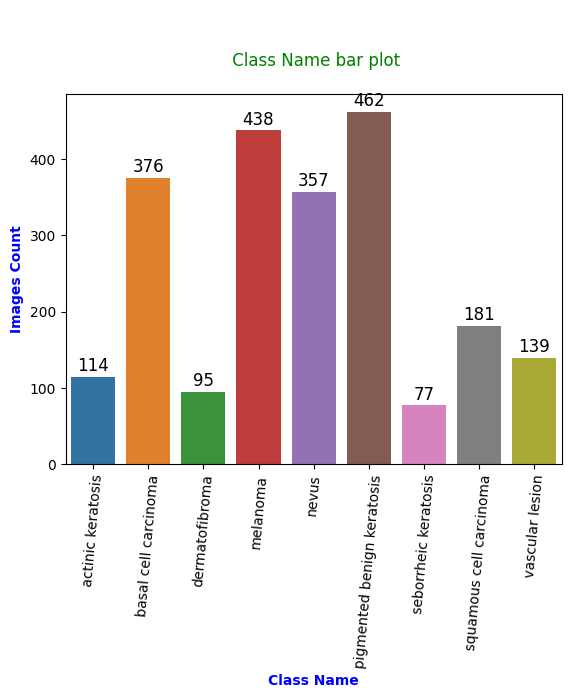

In [ ]:
dict_num_images = dict()
total_number_training_images = len(list(data_dir_train.glob('*/*.*')))
for i, class_name in enumerate(class_names):
    # Sort the images to makes sure, we get to see the same image every time we execute the code
    dict_num_images[class_name] = len(list(data_dir_train.glob(class_name + '/*.jpg')))

# Dataframe of images counts of different classes in training set
df_image_counts = pd.DataFrame(dict_num_images.items(), columns=['Class Name', 'Count'])
df_image_counts['Proportion to total number of images'] = round(df_image_counts.Count / total_number_training_images, 2)
display(df_image_counts)

# Bar plot of image class count
ax = sns.barplot(x='Class Name', y = 'Count', data = df_image_counts)
ax.set_xticklabels(labels=df_image_counts['Class Name'], rotation = 85)
plt.title('\n\n Class Name bar plot\n', c='g')
plt.xlabel('Class Name',fontsize=10,fontweight='bold',c='b')
plt.ylabel('Images Count',fontsize=10,fontweight='bold',c='b')
annotate_plot(ax)
plt.show()

#### **Task 11:** Write your findings here:
#### **Question** - Which class has the least number of samples?
#### **Answer** - 'dermatofibroma' category has least number of samples and the count of it is 95, which is 0.04% of the total number of training images provided.
#### **Question** - Which classes dominate the data in terms proportionate number of samples?
#### **Answer** - 'pigmented benign keratosis' dominate the data in terms proportionate number of samples with a proportion of 21% followed by 'melanoma' with a proportion of 20% followed by 'basal cell carcinoma' with a proportion of 17%

In [ ]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation=layers.LeakyReLU()),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation=layers.LeakyReLU()),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation=layers.LeakyReLU()),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),# adding 20% dropout to avoid overfit
  layers.Flatten(),
  layers.Dense(128, activation=layers.LeakyReLU()),
  layers.Dense(num_classes, name="outputs")
])

model.compile(optimizer= keras.optimizers.SGD(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

epochs = 30
history = model.fit(
  x =  train_ds,
  validation_data = val_ds,
  epochs = epochs
)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_4 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 90, 90, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 45, 45, 32)       0         
 g2D)                                                 

#### **Task 12:** Rectify the class imbalance

In [ ]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [ ]:
import Augmentor
print('library - ', Augmentor.__name__,' version ' ,Augmentor.__version__)

library -  Augmentor  version  0.2.12


In [ ]:
path_to_training_dataset = str("/content/gdrive/MyDrive/UpGrad/Skin cancer ISIC The International Skin Imaging Collaboration/Train/")
for class_name in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + class_name)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/UpGrad/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7A8635F7F040>: 100%|██████████| 500/500 [00:20<00:00, 24.67 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/UpGrad/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7A8635E7F7C0>: 100%|██████████| 500/500 [00:20<00:00, 24.26 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/UpGrad/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7A8635F7F040>: 100%|██████████| 500/500 [00:18<00:00, 26.36 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/UpGrad/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=3072x2304 at 0x7A8630233F70>: 100%|██████████| 500/500 [01:41<00:00,  4.91 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/UpGrad/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=1504x1129 at 0x7A8634FDBA00>: 100%|██████████| 500/500 [01:40<00:00,  4.97 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/UpGrad/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7A8661B2A1A0>: 100%|██████████| 500/500 [00:19<00:00, 25.29 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/UpGrad/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7A8635E5AB00>: 100%|██████████| 500/500 [00:41<00:00, 12.13 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/UpGrad/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7A8673FD2740>: 100%|██████████| 500/500 [00:20<00:00, 24.91 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/UpGrad/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7A8673FA1090>: 100%|██████████| 500/500 [00:18<00:00, 26.67 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [ ]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [ ]:
path_list = [x for x in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list.head()

['/content/gdrive/MyDrive/UpGrad/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0031506.jpg_36209bd4-a561-40b2-8cee-ddc86e9d0774.jpg',
 '/content/gdrive/MyDrive/UpGrad/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0033456.jpg_884fdd08-7510-4cad-b929-c23ec1c927b1.jpg',
 '/content/gdrive/MyDrive/UpGrad/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0026457.jpg_081aebb9-79ea-47a9-be44-8f24bc954399.jpg',
 '/content/gdrive/MyDrive/UpGrad/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0031108.jpg_274f433e-6f76-4219-ba08-bf565d15f2fa.jpg',
 '/content/gdrive/MyDrive/UpGrad/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_orig

In [ ]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [ ]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [ ]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = pd.concat([original_df, df2])

In [ ]:
new_df['Label'].value_counts()
new_df

,Path,Label
0,/content/gdrive/MyDrive/UpGrad/Skin cancer ISI...,actinic keratosis
1,/content/gdrive/MyDrive/UpGrad/Skin cancer ISI...,actinic keratosis
2,/content/gdrive/MyDrive/UpGrad/Skin cancer ISI...,actinic keratosis
3,/content/gdrive/MyDrive/UpGrad/Skin cancer ISI...,actinic keratosis
4,/content/gdrive/MyDrive/UpGrad/Skin cancer ISI...,actinic keratosis
...,...,...
4495,/content/gdrive/MyDrive/UpGrad/Skin cancer ISI...,vascular lesion
4496,/content/gdrive/MyDrive/UpGrad/Skin cancer ISI...,vascular lesion
4497,/content/gdrive/MyDrive/UpGrad/Skin cancer ISI...,vascular lesion
4498,/content/gdrive/MyDrive/UpGrad/Skin cancer ISI...,vascular lesion


So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Task 13**: Train the model on the data created using Augmentor

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

#### **Task 13.1:** Create a training dataset

In [ ]:
# data_dir_train= data_dir_train
data_dir_train = pathlib.Path("/content/gdrive/MyDrive/UpGrad/Skin cancer ISIC The International Skin Imaging Collaboration with Image Augmentation/Train")
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Task 13.2:** Create a validation dataset

In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [ ]:
num_classes = len(train_ds.class_names)

AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

#### **Task 13.3:** Create your model (make sure to include normalization)

In [ ]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation=layers.LeakyReLU()),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation=layers.LeakyReLU()),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation=layers.LeakyReLU()),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),# adding 20% dropout to avoid overfit
  layers.Flatten(),
  layers.Dense(128, activation=layers.LeakyReLU()),
  layers.Dense(num_classes, name="outputs")
])

model.compile(optimizer= keras.optimizers.SGD(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

epochs = 30
history = model.fit(
  x =  train_ds,
  validation_data = val_ds,
  epochs = epochs
)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_5 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_15 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 90, 90, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 45, 45, 32)       0         
 g2D)                                                 

In [49]:
## Model

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)), # With rescaling we are also making sure the values will be in floats for accuracy as well as it helps a bit with performance while training the model as it avoid data type conversion from int to float.
  layers.Conv2D(filters = 16, kernel_size = 3, padding='same', activation='relu'), # padding='same', which means zero padding with original dimension is retained
  layers.BatchNormalization(),# For normalizing the data input to next layer, which is a pooling layer here. Normalizing the data for training speed, stability, and overall performance.
  layers.MaxPooling2D(), # Default pool_size = (2, 2)
  layers.Conv2D(filters = 32, kernel_size = 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Conv2D(filters = 64, kernel_size = 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),# Flatten the data before giving to fully connected dense layers
  layers.Dense(units = 128),
  layers.BatchNormalization(),
  layers.Activation('relu'),
  layers.Dropout(0.2),
  layers.Dense(units = num_classes) #  # dense layer with 9 neuron to predict 9 different categories
])

In [50]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_6 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_18 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 batch_normalization (BatchN  (None, 180, 180, 16)     64        
 ormalization)                                                   
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 90, 90, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 batch_normalization_1 (Batc  (None, 90, 90, 32)      

#### **Task 13.4:** Compile your model (Choose optimizer and loss function appropriately)

In [51]:
### Choosing adam optimiser and SparseCategoricalCrossentropy loss function
model.compile(optimizer= keras.optimizers.SGD(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),# Set from_logits=True to apply softmax activation to output
              metrics=['accuracy'])

#### **Task 13.5:**  Train your model

In [52]:
epochs = 30
history = model.fit(
  train_ds,
  validation_data = val_ds,
  epochs = epochs
)

Epoch 1/30
169/169 [==============================] - 9s 44ms/step - loss: 1.4457 - accuracy: 0.4744 - val_loss: 2.4636 - val_accuracy: 0.1463
Epoch 2/30
169/169 [==============================] - 7s 43ms/step - loss: 0.9774 - accuracy: 0.6563 - val_loss: 1.8660 - val_accuracy: 0.2658
Epoch 3/30
169/169 [==============================] - 7s 41ms/step - loss: 0.7117 - accuracy: 0.7760 - val_loss: 1.2847 - val_accuracy: 0.5316
Epoch 4/30
169/169 [==============================] - 7s 42ms/step - loss: 0.5429 - accuracy: 0.8355 - val_loss: 1.3602 - val_accuracy: 0.5137
Epoch 5/30
169/169 [==============================] - 7s 41ms/step - loss: 0.4169 - accuracy: 0.8850 - val_loss: 0.8021 - val_accuracy: 0.7179
Epoch 6/30
169/169 [==============================] - 7s 42ms/step - loss: 0.3212 - accuracy: 0.9151 - val_loss: 0.8768 - val_accuracy: 0.6830
Epoch 7/30
169/169 [==============================] - 7s 42ms/step - loss: 0.2609 - accuracy: 0.9375 - val_loss: 0.6405 - val_accuracy: 0.7862

In [53]:
### Choosing adam optimiser and SparseCategoricalCrossentropy loss function
model.compile(optimizer= keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),# Set from_logits=True to apply softmax activation to output
              metrics=['accuracy'])

In [54]:
epochs = 30
history = model.fit(
  train_ds,
  validation_data = val_ds,
  epochs = epochs
)

Epoch 1/30
169/169 [==============================] - 11s 44ms/step - loss: 0.9021 - accuracy: 0.6882 - val_loss: 1.9956 - val_accuracy: 0.4655
Epoch 2/30
169/169 [==============================] - 7s 44ms/step - loss: 0.3527 - accuracy: 0.8807 - val_loss: 0.9272 - val_accuracy: 0.6830
Epoch 3/30
169/169 [==============================] - 7s 42ms/step - loss: 0.2261 - accuracy: 0.9256 - val_loss: 0.6133 - val_accuracy: 0.8040
Epoch 4/30
169/169 [==============================] - 7s 43ms/step - loss: 0.1362 - accuracy: 0.9570 - val_loss: 0.6121 - val_accuracy: 0.7966
Epoch 5/30
169/169 [==============================] - 7s 43ms/step - loss: 0.1210 - accuracy: 0.9607 - val_loss: 0.6326 - val_accuracy: 0.7921
Epoch 6/30
169/169 [==============================] - 7s 42ms/step - loss: 0.0969 - accuracy: 0.9659 - val_loss: 0.7113 - val_accuracy: 0.7810
Epoch 7/30
169/169 [==============================] - 7s 43ms/step - loss: 0.0887 - accuracy: 0.9687 - val_loss: 0.7177 - val_accuracy: 0.771

In [80]:
## Model

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)), # With rescaling we are also making sure the values will be in floats for accuracy as well as it helps a bit with performance while training the model as it avoid data type conversion from int to float.
  layers.Conv2D(filters = 16, kernel_size = 3, padding='same', activation=layers.LeakyReLU()), # padding='same', which means zero padding with original dimension is retained
  layers.BatchNormalization(),# For normalizing the data input to next layer, which is a pooling layer here. Normalizing the data for training speed, stability, and overall performance.
  layers.MaxPooling2D(), # Default pool_size = (2, 2)
  layers.Dropout(0.1),
  layers.Conv2D(filters = 32, kernel_size = 3, padding='same', activation=layers.LeakyReLU()),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Conv2D(filters = 64, kernel_size = 3, padding='same', activation=layers.LeakyReLU()),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Dropout(0.1),
  layers.Conv2D(filters = 128, kernel_size = 3, padding='same', activation=layers.ReLU()),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),# Flatten the data before giving to fully connected dense layers
  layers.Dense(units = 128),
  layers.BatchNormalization(),
  layers.Activation('relu'),
  layers.Dropout(0.25),
  layers.Dense(units = num_classes) #  # dense layer with 9 neuron to predict 9 different categories
])

model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_15 (Rescaling)    (None, 180, 180, 3)       0         
                                                                 
 conv2d_49 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 batch_normalization_40 (Bat  (None, 180, 180, 16)     64        
 chNormalization)                                                
                                                                 
 max_pooling2d_49 (MaxPoolin  (None, 90, 90, 16)       0         
 g2D)                                                            
                                                                 
 dropout_35 (Dropout)        (None, 90, 90, 16)        0         
                                                                 
 conv2d_50 (Conv2D)          (None, 90, 90, 32)      

In [81]:
### Choosing adam optimiser and SparseCategoricalCrossentropy loss function
model.compile(optimizer= keras.optimizers.SGD(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),# Set from_logits=True to apply softmax activation to output
              metrics=['accuracy'])

In [ ]:
epochs = 30
history = model.fit(
  train_ds,
  validation_data = val_ds,
  epochs = epochs
)

Epoch 1/30
169/169 [==============================] - 12s 57ms/step - loss: 1.6011 - accuracy: 0.4071 - val_loss: 2.4939 - val_accuracy: 0.1151
Epoch 2/30
169/169 [==============================] - 8s 50ms/step - loss: 1.2301 - accuracy: 0.5568 - val_loss: 2.3151 - val_accuracy: 0.1373
Epoch 3/30
169/169 [==============================] - 9s 51ms/step - loss: 1.0621 - accuracy: 0.6230 - val_loss: 1.6206 - val_accuracy: 0.4083
Epoch 4/30
169/169 [==============================] - 8s 50ms/step - loss: 0.9518 - accuracy: 0.6721 - val_loss: 1.2386 - val_accuracy: 0.5702
Epoch 5/30
169/169 [==============================] - 8s 49ms/step - loss: 0.8353 - accuracy: 0.7133 - val_loss: 1.5317 - val_accuracy: 0.4729
Epoch 6/30
169/169 [==============================] - 8s 49ms/step - loss: 0.7339 - accuracy: 0.7567 - val_loss: 0.9278 - val_accuracy: 0.6771
Epoch 7/30
169/169 [==============================] - 9s 51ms/step - loss: 0.6634 - accuracy: 0.7782 - val_loss: 1.0788 - val_accuracy: 0.612

#### **Task 13.6:**  Visualize the model results

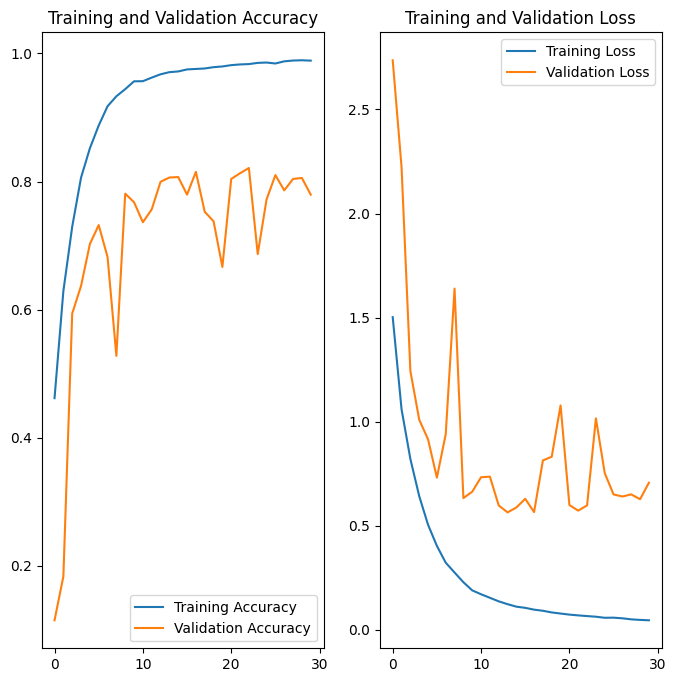

In [58]:
visualize_training_results(phistory = history, pepochs = epochs)

#### **Task 13.7:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?

1. We can see that the accuracy of the model is increasing steadily with training data with each epoch but is fluctuating a lot in the begining and in the middle with validation data, it starts to get better in the end overall with validation data. But, the model seem to be still overfitting a bit.

2. We can say that the problem of overfitting has gotten better with rectification of class imbalance by using Augmentor to add more samples across all classes so that none of the classes have very few samples. Rectification of class imbalance helped with model accuracy

3. We can see that the loss of the model is decreasing steadily with training data with each epoch but is fluctuating a lot in the begining and in the middle with validation data, it starts to get better in the end overall with validation data





#### Let us build an Inception Model and check the accuracy of the model

####  Create a Training dataset

In [ ]:
# data_dir_train= data_dir_train
data_dir_train = pathlib.Path("/content/gdrive/MyDrive/UpGrad/Skin cancer ISIC The International Skin Imaging Collaboration with Image Augmentation/Train")
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

NameError: ignored

####  Create a validation dataset

In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [ ]:
num_classes = 9
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
# Define Inception module
def inception_module(x, filters):
    conv1x1 = layers.Conv2D(filters[0], (1, 1))(x)
    conv1x1 = layers.BatchNormalization()(conv1x1)
    conv1x1 = layers.Activation('relu')(conv1x1)

    conv3x3 = layers.Conv2D(filters[1], (3, 3), padding='same')(x)
    conv3x3 = layers.BatchNormalization()(conv3x3)
    conv3x3 = layers.Activation('relu')(conv3x3)

    conv5x5 = layers.Conv2D(filters[2], (5, 5), padding='same')(x)
    conv5x5 = layers.BatchNormalization()(conv5x5)
    conv5x5 = layers.Activation('relu')(conv5x5)
    maxpool = layers.MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)

    return layers.concatenate([conv1x1, conv3x3, conv5x5, maxpool], axis=-1) # axis=-1 to concatenate using the last axis, which is the number of channels RGB in the current model

# Build the Inception model
input_layer = layers.Input(shape=(180, 180, 3))

x = layers.Conv2D(64, (7, 7), strides = (2, 2), padding = 'same')(input_layer)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

x = layers.MaxPooling2D((3, 3), strides = (2, 2), padding = 'same')(x)

x = layers.Conv2D(192, (3, 3), padding = 'same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

x = layers.MaxPooling2D((3, 3), strides = (2, 2), padding = 'same')(x)

# Apply Inception modules
x = inception_module(x, [64, 128, 32])
x = inception_module(x, [128, 192, 96])
x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

# Add fully connected layers
# x = layers.Dropout(0.2)(x)
x = layers.Flatten()(x)
x = layers.Dense(1024, activation = 'relu')(x)
output_layer = layers.Dense(9, activation = 'softmax')(x)

# Create the model
inception_model = keras.models.Model(inputs = input_layer, outputs = output_layer)

# Compile and train the model
inception_model.compile(optimizer = 'SGD', loss = 'SparseCategoricalCrossentropy', metrics = ['accuracy'])



In [ ]:
# Model summary
inception_model.summary()



Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_22 (InputLayer)          [(None, 180, 180, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_153 (Conv2D)            (None, 90, 90, 64)   9472        ['input_22[0][0]']               
                                                                                                  
 batch_normalization_56 (BatchN  (None, 90, 90, 64)  256         ['conv2d_153[0][0]']             
 ormalization)                                                                                    
                                                                                           

In [ ]:
# Fit the model
history = inception_model.fit(
  train_ds,
  validation_data = val_ds,
  epochs = 25,
  batch_size = 32
)

Epoch 1/25
169/169 [==============================] - ETA: 0s - loss: 9.3999 - accuracy: 0.2046

In [ ]:
visualize_training_results(phistory = history, pepochs = 30)

NameError: ignored